In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
# from torchvision.transforms import ToTensor, ToPILImage
import torchvision.transforms as transforms
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torchvision.models as models

In [2]:
sem_df=pd.read_excel("SEM_Final.xlsx")
print(sem_df.shape)
sem_df.head()

(1603, 15)


,link,title,num,letter,hydrogel,sentence,figure,SEM,SEM_img,scale,modulus,measurement,modification,skip,Unnamed: 14
0,https://pubs.acs.org/doi/10.1021/acsami.5b00184,Tough and Biocompatible Hydrogels Based on in ...,S3.,a,PVA,SEM images of the dehydrated PVA,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM3.jpg,-5.0,compressive,42.3 kPa,NaN,NaN,NaN
1,https://pubs.acs.org/doi/10.1021/acsami.5b00185,Tough and Biocompatible Hydrogels Based on in ...,S3.,a,PVA,SEM images of the dehydrated PVA,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM5.jpg,-6.0,compressive,42.3 kPa,NaN,NaN,NaN
2,https://pubs.acs.org/doi/10.1021/acsami.5b00186,Tough and Biocompatible Hydrogels Based on in ...,S3.,b,E-cGO0.5/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM1.jpg,-5.0,compressive,60 kPa,NaN,NaN,NaN
3,https://pubs.acs.org/doi/10.1021/acsami.5b00187,Tough and Biocompatible Hydrogels Based on in ...,S3.,b,E-cGO0.5/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM0.jpg,-6.0,compressive,60 kPa,NaN,NaN,NaN
4,https://pubs.acs.org/doi/10.1021/acsami.5b00188,Tough and Biocompatible Hydrogels Based on in ...,S3.,c,E-cGO1.0/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM6.jpg,-5.0,compressive,60 kPa,NaN,NaN,NaN


In [3]:
sem_df.isna().sum()

link               0
title              0
num                0
letter             4
hydrogel           0
sentence          16
figure             0
SEM                0
SEM_img          746
scale            743
modulus          766
measurement      772
modification    1603
skip             796
Unnamed: 14     1414
dtype: int64

In [4]:
measure_sem_df = sem_df[sem_df['skip'].isna()]
measure_sem_df = measure_sem_df[measure_sem_df['measurement'].isna()]
print(measure_sem_df.shape)
measure_sem_df.to_csv("missing_measurement.csv")
measure_sem_df.head()

(0, 15)


,link,title,num,letter,hydrogel,sentence,figure,SEM,SEM_img,scale,modulus,measurement,modification,skip,Unnamed: 14


In [5]:
parsed_sem_df = sem_df[sem_df['measurement'].notna()]
parsed_sem_df = parsed_sem_df[parsed_sem_df['SEM_img'].notna()]
print(parsed_sem_df['skip'].isna().sum())
parsed_sem_df = parsed_sem_df[parsed_sem_df['skip'].isna()]
print(parsed_sem_df.shape)
parsed_sem_df.head()

793
(793, 15)


,link,title,num,letter,hydrogel,sentence,figure,SEM,SEM_img,scale,modulus,measurement,modification,skip,Unnamed: 14
0,https://pubs.acs.org/doi/10.1021/acsami.5b00184,Tough and Biocompatible Hydrogels Based on in ...,S3.,a,PVA,SEM images of the dehydrated PVA,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM3.jpg,-5.0,compressive,42.3 kPa,NaN,NaN,NaN
1,https://pubs.acs.org/doi/10.1021/acsami.5b00185,Tough and Biocompatible Hydrogels Based on in ...,S3.,a,PVA,SEM images of the dehydrated PVA,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM5.jpg,-6.0,compressive,42.3 kPa,NaN,NaN,NaN
2,https://pubs.acs.org/doi/10.1021/acsami.5b00186,Tough and Biocompatible Hydrogels Based on in ...,S3.,b,E-cGO0.5/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM1.jpg,-5.0,compressive,60 kPa,NaN,NaN,NaN
3,https://pubs.acs.org/doi/10.1021/acsami.5b00187,Tough and Biocompatible Hydrogels Based on in ...,S3.,b,E-cGO0.5/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM0.jpg,-6.0,compressive,60 kPa,NaN,NaN,NaN
4,https://pubs.acs.org/doi/10.1021/acsami.5b00188,Tough and Biocompatible Hydrogels Based on in ...,S3.,c,E-cGO1.0/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM6.jpg,-5.0,compressive,60 kPa,NaN,NaN,NaN


In [6]:
parsed_sem_df['skip'].value_counts()

Series([], Name: skip, dtype: int64)

In [7]:
parsed_sem_df.isna().sum()

link              0
title             0
num               0
letter            4
hydrogel          0
sentence          8
figure            0
SEM               0
SEM_img           0
scale             4
modulus           0
measurement       0
modification    793
skip            793
Unnamed: 14     712
dtype: int64

In [8]:
missing_sem_df = parsed_sem_df[parsed_sem_df['SEM_img'].isna()]
# missing_sem_df.to_csv("missing_sem_rows.csv")
missing_sem_df.head(40) 

,link,title,num,letter,hydrogel,sentence,figure,SEM,SEM_img,scale,modulus,measurement,modification,skip,Unnamed: 14


In [9]:
missing_sem_df['skip'].value_counts()

Series([], Name: skip, dtype: int64)

In [10]:
parsed_sem_df['img_path'] = parsed_sem_df.apply(lambda x: os.path.join(x['SEM'],x['SEM_img']),axis=1)

In [11]:
parsed_sem_df['img_path']

0          sem/10.1021_acsami.5b00184\SEM\supp_7_SEM3.jpg
1          sem/10.1021_acsami.5b00184\SEM\supp_7_SEM5.jpg
2          sem/10.1021_acsami.5b00184\SEM\supp_7_SEM1.jpg
3          sem/10.1021_acsami.5b00184\SEM\supp_7_SEM0.jpg
4          sem/10.1021_acsami.5b00184\SEM\supp_7_SEM6.jpg
                              ...                        
1598    sem/10.1021_acs.langmuir.8b02918\SEM\la-2018-0...
1599    sem/10.1021_acs.langmuir.8b02918\SEM\la-2018-0...
1600    sem/10.1021_acsbiomaterials.0c00143\SEM\ab0c00...
1601    sem/10.1021_acsbiomaterials.0c00143\SEM\ab0c00...
1602    sem/10.1021_acsbiomaterials.0c00143\SEM\ab0c00...
Name: img_path, Length: 793, dtype: object

In [12]:
# clean dataset to get correct labels
parsed_sem_df['measurement']

def convert_measurement(string):
    string.replace(" ","")
    kpa = ["KPa","kPa", "Kpa", "kpa","KpA"]
    mpa = ["Mpa","MPa"]
    gpa = ["GPa","Gpa"]
    
    if any(KPA in string for KPA in kpa):
        for KPA in kpa:
            string = string.replace(KPA,"")
        string = string.strip()
        value = float(string)
        value *= 1000 
    elif any(MPA in string for MPA in mpa):
        for MPA in mpa:
            string = string.replace(MPA,"")
        string = string.strip()
        value = float(string)
        value *= 1000000
    elif any(GPA in string for GPA in gpa):
        for GPA in gpa:
            string = string.replace(GPA,"")
        string = string.strip()
        value = float(string)
        value *= 1000000000
    elif "Pa" in string:
        string = string.replace("Pa","")
        string = string.strip()
        value = float(string)
    else:
        print(string)
        return
    return value
parsed_sem_df['measurement'].apply(convert_measurement)

0        42300.0
1        42300.0
2        60000.0
3        60000.0
4        60000.0
          ...   
1598    157000.0
1599    162000.0
1600      8000.0
1601     50000.0
1602    120000.0
Name: measurement, Length: 793, dtype: float64

In [13]:
transform = transforms.Compose(
    [transforms.Resize(256),
#     transforms.Grayscale(3),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0,1)
    ]
)
eval_transform = transform = transforms.Compose(
    [transforms.Resize(256),
#     transforms.Grayscale(3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0,1)
    ]
)

793
(793, 16)
Length: 793


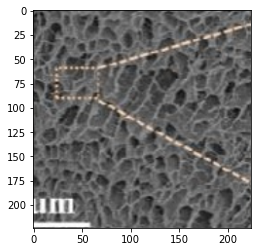

In [14]:
class semDataset(Dataset):
    def __init__(self,filepath="SEM_Final.xlsx", transform = None):
        sem_df=pd.read_excel("SEM_Final.xlsx")
        parsed_sem_df = sem_df[sem_df['measurement'].notna()]
        parsed_sem_df = parsed_sem_df[parsed_sem_df['SEM_img'].notna()]
        print(parsed_sem_df['skip'].isna().sum())
        parsed_sem_df = parsed_sem_df[parsed_sem_df['skip'].isna()]
        parsed_sem_df['img_path'] = parsed_sem_df.apply(lambda x: os.path.join(x['SEM'],x['SEM_img']),axis=1)
        print(parsed_sem_df.shape)
        parsed_sem_df['measurement']= parsed_sem_df['measurement'].apply(self.convert_measurement)
        self.sem_df = parsed_sem_df
        self.transform = transform
    
    def __len__(self):
        return parsed_sem_df.shape[0]
    
    def convert_measurement(self,string):
        string.replace(" ","")
        kpa = ["KPa","kPa", "Kpa", "kpa","KpA"]
        mpa = ["Mpa","MPa"]
        gpa = ["GPa","Gpa"]

        if any(KPA in string for KPA in kpa):
            for KPA in kpa:
                string = string.replace(KPA,"")
            string = string.strip()
            value = float(string)
            value *= 1000 
        elif any(MPA in string for MPA in mpa):
            for MPA in mpa:
                string = string.replace(MPA,"")
            string = string.strip()
            value = float(string)
            value *= 1000000
        elif any(GPA in string for GPA in gpa):
            for GPA in gpa:
                string = string.replace(GPA,"")
            string = string.strip()
            value = float(string)
            value *= 1000000000
        elif "Pa" in string:
            string = string.replace("Pa","")
            string = string.strip()
            value = float(string)
        else:
            print(string)
            return
        return np.log10(value)
    def __getitem__(self,index):
        image = Image.open(self.sem_df.iloc[index]["img_path"])
        label = self.sem_df.iloc[index]["measurement"]
        if self.transform is not None:
            image = self.transform(image)
        label = torch.tensor(label)
        return image, label
semdata = semDataset(transform=transform)
print(f"Length: {len(semdata)}")
image, label=semdata.__getitem__(0)
plt.imshow(image.permute(1,2,0))

In [15]:
# Create train test split, as 60/20/20 split
train_idx, test_idx = train_test_split(list(range(len(semdata))),test_size = 0.2, random_state=42)
train_idx, val_idx =  train_test_split(train_idx, test_size = 0.25, random_state=42)
train_data = torch.utils.data.Subset(semDataset(transform=transform),train_idx)
val_data = torch.utils.data.Subset(semDataset(transform=eval_transform),val_idx)
test_data = torch.utils.data.Subset(semDataset(transform=eval_transform),test_idx)
print(f"Train dataset length: {len(train_data)}")
print(f"Validation dataset length: {len(val_data)}")
print(f"Test dataset length: {len(test_data)}")

793
(793, 16)
793
(793, 16)
793
(793, 16)
Train dataset length: 475
Validation dataset length: 159
Test dataset length: 159


In [16]:
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, 
                          shuffle=True, num_workers=0, persistent_workers=False)
val_loader = DataLoader(val_data, batch_size=batch_size*4, 
                          shuffle=False, num_workers=0, persistent_workers=False)
test_loader = DataLoader(test_data, batch_size=batch_size*4, 
                          shuffle=False, num_workers=0, persistent_workers=False)

In [17]:
resolution = []
cannot_open = []
low_res = []
to_pil = transforms.ToPILImage()
for i in range(len(semdata)):
    try:
        image, label=semdata.__getitem__(i)
#         image = image.permute(1,2,0)
        image = to_pil(image)
        if image.size[0]<128 or image.size[1]<128:
            low_res.append(i)
        resolution.append(image.size)
    except:
        print(parsed_sem_df.iloc[i,:]["img_path"])
        cannot_open.append(i)
        print(f"Cannot open {i}")
parsed_sem_df.iloc[cannot_open,:].to_csv("cannot_open.csv")
print(f"We cannot open {len(cannot_open)} files")
print(f"Smallest resolution is {min(resolution)}")
print(f"Largest resolution is {max(resolution)}")

We cannot open 0 files
Smallest resolution is (224, 224)
Largest resolution is (224, 224)


In [18]:
low_res

[]

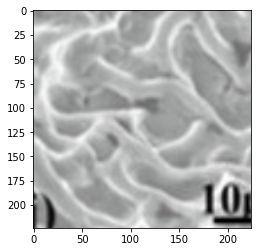

In [19]:
plt.imshow(semdata.__getitem__(615)[0].permute(1,2,0))

In [20]:
type(semdata.__getitem__(615)[0])

torch.Tensor

In [21]:
# Define a model

class SEMPro(torch.nn.Module):
    def __init__(self):
        super(SEMPro,self).__init__()
        self.cnn_block = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,kernel_size=3,stride=2),
            torch.nn.ELU(inplace=True),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(16),
            torch.nn.Conv2d(16,8,kernel_size=3,stride=2),
            torch.nn.ELU(inplace=True),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(8)         
        )
        
        self.linear_layer = torch.nn.Sequential(
            torch.nn.LazyLinear(64),
            torch.nn.ELU(inplace=True),
            torch.nn.BatchNorm1d(64),
            torch.nn.Linear(64,32),
            torch.nn.BatchNorm1d(32),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(32,1)
        )
    
    def forward(self, x):
        x = self.cnn_block(x)
#         print(x.shape)
        x = x.view(x.size(0),-1)
#         print(x.shape)
        x = self.linear_layer(x)
        return x

In [22]:
class SEMPro_resNext(torch.nn.Module):
    def __init__(self,large = False, pretrained = False):
        super(SEMPro_resNext,self).__init__()
        if large:
            self.model = models.resnext101_32x8d(pretrained=pretrained)
        else:
            self.model = models.resnext50_32x4d(pretrained=pretrained)
        self.model.fc = torch.nn.Linear(2048,1)
        # Change relu to elu
        self.replace_layers(self.model, torch.nn.ReLU, torch.nn.ELU())
    def forward(self,x):
        x = self.model(x)
        return x
    ## From https://stackoverflow.com/questions/58297197/how-to-change-activation-layer-in-pytorch-pretrained-module
    def replace_layers(self, model, old, new):
        for n, module in model.named_children():
            if len(list(module.children())) > 0:
                ## compound module, go inside it
                self.replace_layers(module, old, new)
            if isinstance(module, old):
                ## simple module
                setattr(model, n, new)

In [23]:
model = SEMPro_resNext()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6, weight_decay = 0.02)
criterion = torch.nn.L1Loss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20,gamma=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")
model.to(device)
criterion.to(device)
print(model)
# 1/0
# print(semdata.__getitem__(615))
# model.eval()
# print(model.forward(semdata.__getitem__(615)[0].unsqueeze(0).to(device)))
# model.train()

Running on cuda
SEMPro_resNext(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ELU(alpha=1.0)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ELU(alpha=1.0)
        (downs

In [24]:
epochs = 100
print(f"Training for {epochs} epochs")

# training loop
train_mae_loss_list = []
train_mse_loss_list = []
val_mae_loss_list = []
val_mse_loss_list = []
best_mae = 1000000
for epoch in range(epochs):
    print(f"Now running epoch {epoch}")
    #Iterate through training dataset
    train_mae_loss = 0
    train_mse_loss = 0
    val_mae_loss = 0
    val_mse_loss = 0
    model.train()
    for image, label in tqdm(train_loader,desc="Training data: "):
        # Send variables to device
        image = image.to(device)
        label = label.to(device)
        # Zero gradients
        optimizer.zero_grad()
        # Predict values
        pred = model(image)
        # Compute loss
        loss = criterion(pred.squeeze(),label)
        # Backpropagate
        loss.backward()
        # Update parameters
        optimizer.step()
        # Move variables to cpu
        pred = pred.cpu().detach()
        label = label.cpu().detach()
        # Compute losses
        train_mae_loss += mean_absolute_error(pred,label)*image.shape[0]
        train_mse_loss += mean_squared_error(pred,label)*image.shape[0]
    train_mae_loss /= len(train_data)
    train_mse_loss /= len(train_data)
    model.eval()
    # Run validation dataset
    for image, label in tqdm(val_loader,desc="Validation data: "):
        # Send variables to device
        image = image.to(device)
        label = label.to(device)
        # Run model
        pred = model(image)
        # Move variables to cpu
        pred = pred.cpu().detach()
        label = label.cpu().detach()
        # Compute loss
        val_mae_loss += mean_absolute_error(pred,label)*image.shape[0]
        val_mse_loss += mean_squared_error(pred,label)*image.shape[0]
    val_mae_loss /= len(val_data)
    val_mse_loss /= len(val_data)
    print(f"Training losses: MAE = {train_mae_loss}, MSE = {train_mse_loss}")
    print(f"Validation losses: MAE = {val_mae_loss}, MSE = {val_mse_loss}")
    train_mae_loss_list.append(train_mae_loss)
    train_mse_loss_list.append(train_mse_loss)
    val_mae_loss_list.append(val_mae_loss)
    val_mse_loss_list.append(val_mse_loss)
    scheduler.step()
    # Checkpoint best model
    if val_mae_loss < best_mae:
        best_mae = val_mae_loss
        torch.save(model, f"best_resnext_model.pt")

Training for 100 epochs
Now running epoch 0


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Training losses: MAE = 4.321938962101903, MSE = 20.46072743617723
Validation losses: MAE = 3.605066951162045, MSE = 14.978422093959795
Now running epoch 1


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Training losses: MAE = 3.5561589899874937, MSE = 14.551875144016659
Validation losses: MAE = 2.630416596607658, MSE = 8.956977498187522
Now running epoch 2


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.70it/s]


Training losses: MAE = 2.2346860746870996, MSE = 6.91486441678453
Validation losses: MAE = 1.4575993562015046, MSE = 3.4179296149265177
Now running epoch 3


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.59it/s]


Training losses: MAE = 1.2752742612573107, MSE = 2.6505050311756837
Validation losses: MAE = 1.149586265780497, MSE = 2.3733648974237047
Now running epoch 4


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Training losses: MAE = 1.0607006014916023, MSE = 1.8887415761233148
Validation losses: MAE = 1.1217612827366223, MSE = 2.1529340369132144
Now running epoch 5


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Training losses: MAE = 1.0052253784672611, MSE = 1.6875224743492943
Validation losses: MAE = 1.1277089152656863, MSE = 2.144621413265975
Now running epoch 6


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]


Training losses: MAE = 0.9775356249495343, MSE = 1.6315487260671988
Validation losses: MAE = 1.0613940991450597, MSE = 1.8080151967031537
Now running epoch 7


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Training losses: MAE = 0.9315800541997821, MSE = 1.5188505584090064
Validation losses: MAE = 1.0565288296223945, MSE = 1.7758181118519423
Now running epoch 8


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Training losses: MAE = 0.8899919564106473, MSE = 1.3985991351735019
Validation losses: MAE = 1.0432672380634234, MSE = 1.8089327871384908
Now running epoch 9


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Training losses: MAE = 0.8554285536883774, MSE = 1.3669588143174551
Validation losses: MAE = 1.077510610978349, MSE = 2.005332979820336
Now running epoch 10


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Training losses: MAE = 0.8166368344532748, MSE = 1.2598104539705706
Validation losses: MAE = 1.0902021597929645, MSE = 1.91602612356177
Now running epoch 11


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Training losses: MAE = 0.8047841053699109, MSE = 1.1955211464186404
Validation losses: MAE = 1.0921805560852642, MSE = 1.7782455889244477
Now running epoch 12


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]


Training losses: MAE = 0.798739687684689, MSE = 1.2023964084447
Validation losses: MAE = 1.0597908311765831, MSE = 1.835297955900866
Now running epoch 13


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.60it/s]


Training losses: MAE = 0.7392799031143448, MSE = 1.0528749657067946
Validation losses: MAE = 1.0669212757317832, MSE = 1.7539618774217793
Now running epoch 14


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Training losses: MAE = 0.7517934678106096, MSE = 1.067242988508585
Validation losses: MAE = 1.0557965174796846, MSE = 1.7565217423503627
Now running epoch 15


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Training losses: MAE = 0.6985412148117133, MSE = 0.987938440145386
Validation losses: MAE = 1.0820897980631023, MSE = 1.8442112489832916
Now running epoch 16


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Training losses: MAE = 0.6555469527993054, MSE = 0.8910594864718531
Validation losses: MAE = 1.057426570798785, MSE = 1.7468823057648624
Now running epoch 17


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Training losses: MAE = 0.6189724181237283, MSE = 0.8101384168587044
Validation losses: MAE = 1.1202810419623115, MSE = 1.8935950438020654
Now running epoch 18


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Training losses: MAE = 0.5671754297764928, MSE = 0.6820776417169053
Validation losses: MAE = 1.0679341377043055, MSE = 1.745606825067857
Now running epoch 19


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82it/s]


Training losses: MAE = 0.6288254425716276, MSE = 0.8123731670542547
Validation losses: MAE = 1.0653290561595583, MSE = 1.888353877564584
Now running epoch 20


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Training losses: MAE = 0.6109423561791857, MSE = 0.72319457553633
Validation losses: MAE = 1.0495061126824603, MSE = 1.765730343203473
Now running epoch 21


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Training losses: MAE = 0.531981972735944, MSE = 0.6163221701877942
Validation losses: MAE = 1.0413173516320144, MSE = 1.6796513211974395
Now running epoch 22


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]


Training losses: MAE = 0.5033578581359535, MSE = 0.5609498022806692
Validation losses: MAE = 1.0894958199797478, MSE = 1.8157011428106344
Now running epoch 23


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Training losses: MAE = 0.5304596084651235, MSE = 0.6073363563878206
Validation losses: MAE = 1.036071566255886, MSE = 1.6734033013478113
Now running epoch 24


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Training losses: MAE = 0.49726332422900965, MSE = 0.5344765665792399
Validation losses: MAE = 1.0432843773079958, MSE = 1.670805252925472
Now running epoch 25


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82it/s]


Training losses: MAE = 0.5332260980062137, MSE = 0.6282330665081842
Validation losses: MAE = 1.0949171298397375, MSE = 1.85222307072064
Now running epoch 26


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Training losses: MAE = 0.4782212414644727, MSE = 0.48354823367904
Validation losses: MAE = 1.0521895581643441, MSE = 1.6948228137470411
Now running epoch 27


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Training losses: MAE = 0.49385862655924073, MSE = 0.5514019127205818
Validation losses: MAE = 1.0844758494060258, MSE = 1.8075775759116444
Now running epoch 28


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]


Training losses: MAE = 0.5025631065985701, MSE = 0.5521883180975735
Validation losses: MAE = 1.0372560135208269, MSE = 1.6759537692513147
Now running epoch 29


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Training losses: MAE = 0.5130871130690284, MSE = 0.5399981434115888
Validation losses: MAE = 1.0463346209776578, MSE = 1.699278796148575
Now running epoch 30


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Training losses: MAE = 0.46080056741304504, MSE = 0.45129900026441755
Validation losses: MAE = 1.1010170031585136, MSE = 1.943129169458068
Now running epoch 31


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Training losses: MAE = 0.4889570141804444, MSE = 0.49874176384833674
Validation losses: MAE = 1.0740111400945294, MSE = 1.769905741060529
Now running epoch 32


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Training losses: MAE = 0.4842517830209438, MSE = 0.4752220413736696
Validation losses: MAE = 1.0608065183141315, MSE = 1.7374981273054173
Now running epoch 33


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Training losses: MAE = 0.4625475525585408, MSE = 0.4708430991824743
Validation losses: MAE = 1.050576775594949, MSE = 1.7117205304780871
Now running epoch 34


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Training losses: MAE = 0.4787242397153202, MSE = 0.46882092324412544
Validation losses: MAE = 1.0369873010318162, MSE = 1.6492623873173402
Now running epoch 35


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]


Training losses: MAE = 0.4678461457238709, MSE = 0.4722502995170162
Validation losses: MAE = 1.0898439343297535, MSE = 1.8743184483525814
Now running epoch 36


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Training losses: MAE = 0.4550956178415221, MSE = 0.4532864975490084
Validation losses: MAE = 1.0740443601491123, MSE = 1.7888776660705832
Now running epoch 37


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Training losses: MAE = 0.4352907695983522, MSE = 0.40332028182433144
Validation losses: MAE = 1.0763185820377315, MSE = 1.7679739204270422
Now running epoch 38


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Training losses: MAE = 0.4309814238492946, MSE = 0.37676340454814183
Validation losses: MAE = 1.0802985546321004, MSE = 1.8296727044820864
Now running epoch 39


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Training losses: MAE = 0.4358640674965181, MSE = 0.41294281970181795
Validation losses: MAE = 1.0872349952668432, MSE = 1.817466097370672
Now running epoch 40


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Training losses: MAE = 0.41577917149224275, MSE = 0.37867969782970096
Validation losses: MAE = 1.052904465924332, MSE = 1.7011500291206811
Now running epoch 41


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]


Training losses: MAE = 0.4282225740897739, MSE = 0.38835021818088333
Validation losses: MAE = 1.0586802923439953, MSE = 1.705003499885573
Now running epoch 42


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Training losses: MAE = 0.43592236660468714, MSE = 0.3962982095304759
Validation losses: MAE = 1.067224971423748, MSE = 1.7429611595923904
Now running epoch 43


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]


Training losses: MAE = 0.43947121955605767, MSE = 0.38846016528214034
Validation losses: MAE = 1.0578752665712137, MSE = 1.7125751481187548
Now running epoch 44


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]


Training losses: MAE = 0.42170070318223435, MSE = 0.3760490056603978
Validation losses: MAE = 1.072795278410888, MSE = 1.7583290312063762
Now running epoch 45


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Training losses: MAE = 0.439898388919349, MSE = 0.41194467740634666
Validation losses: MAE = 1.0822272852897308, MSE = 1.794319965085068
Now running epoch 46


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Training losses: MAE = 0.42764048534614707, MSE = 0.39001457054563554
Validation losses: MAE = 1.0585107575992698, MSE = 1.7029094861961378
Now running epoch 47


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Training losses: MAE = 0.40409302967987615, MSE = 0.3693270585922626
Validation losses: MAE = 1.074504992853622, MSE = 1.7682642103474242
Now running epoch 48


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Training losses: MAE = 0.4206528961073516, MSE = 0.3987603459574577
Validation losses: MAE = 1.0622560666967016, MSE = 1.7103592489735049
Now running epoch 49


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Training losses: MAE = 0.4265209111176596, MSE = 0.3970260663487866
Validation losses: MAE = 1.0805424278484919, MSE = 1.7914223953923432
Now running epoch 50


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Training losses: MAE = 0.4051636148712551, MSE = 0.33421662707549077
Validation losses: MAE = 1.0769824400764179, MSE = 1.7791159092322015
Now running epoch 51


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]


Training losses: MAE = 0.4235847788409087, MSE = 0.38730343774029913
Validation losses: MAE = 1.0620160733752397, MSE = 1.7106552186313149
Now running epoch 52


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Training losses: MAE = 0.43529327519503, MSE = 0.3906486334073875
Validation losses: MAE = 1.0512395810638624, MSE = 1.7106119016874894
Now running epoch 53


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]


Training losses: MAE = 0.44854881153597176, MSE = 0.39926005999525493
Validation losses: MAE = 1.083101643496967, MSE = 1.8081786935929272
Now running epoch 54


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]


Training losses: MAE = 0.4082318207868665, MSE = 0.3141055313965166
Validation losses: MAE = 1.0616072727004195, MSE = 1.7067276648588716
Now running epoch 55


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Training losses: MAE = 0.45149083906854987, MSE = 0.40320416801204045
Validation losses: MAE = 1.048912701585227, MSE = 1.6931657696045472
Now running epoch 56


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Training losses: MAE = 0.422281393287555, MSE = 0.3704102609490424
Validation losses: MAE = 1.0493512424656546, MSE = 1.681690007359611
Now running epoch 57


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Training losses: MAE = 0.4141289073705565, MSE = 0.34067473654279473
Validation losses: MAE = 1.0649099782524767, MSE = 1.7194310838746498
Now running epoch 58


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Training losses: MAE = 0.420338906947302, MSE = 0.3683738656410269
Validation losses: MAE = 1.0672270445267953, MSE = 1.766955247061951
Now running epoch 59


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]


Training losses: MAE = 0.39892761105709557, MSE = 0.3366728703727606
Validation losses: MAE = 1.0642465122838631, MSE = 1.7611638013323914
Now running epoch 60


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.59it/s]


Training losses: MAE = 0.38782447199957515, MSE = 0.3152557313859574
Validation losses: MAE = 1.0786304034641996, MSE = 1.7854767288867863
Now running epoch 61


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]


Training losses: MAE = 0.4350491836181556, MSE = 0.3777024272208235
Validation losses: MAE = 1.0794199887209706, MSE = 1.802428908381586
Now running epoch 62


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Training losses: MAE = 0.3816354733596674, MSE = 0.34553059105229417
Validation losses: MAE = 1.0760183674921076, MSE = 1.777015609750333
Now running epoch 63


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Training losses: MAE = 0.4179666998963161, MSE = 0.3649680924227001
Validation losses: MAE = 1.0534526396853572, MSE = 1.6927828376431366
Now running epoch 64


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Training losses: MAE = 0.4250019264293351, MSE = 0.37999662614209845
Validation losses: MAE = 1.0415578977698443, MSE = 1.6630690643388246
Now running epoch 65


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Training losses: MAE = 0.43532922755399905, MSE = 0.37180479888220136
Validation losses: MAE = 1.0879100132880186, MSE = 1.8258458811060918
Now running epoch 66


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]


Training losses: MAE = 0.3862077667826886, MSE = 0.3400645628956504
Validation losses: MAE = 1.0730185433336574, MSE = 1.7791398821218818
Now running epoch 67


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Training losses: MAE = 0.3794551698057818, MSE = 0.31251900944589056
Validation losses: MAE = 1.0486505256655891, MSE = 1.685192292946079
Now running epoch 68


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.70it/s]


Training losses: MAE = 0.41656093483317114, MSE = 0.3690433088824101
Validation losses: MAE = 1.0433614346548372, MSE = 1.666062754796192
Now running epoch 69


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.65it/s]


Training losses: MAE = 0.38106555965347255, MSE = 0.3409166866789352
Validation losses: MAE = 1.0620782537485056, MSE = 1.7323478574838669
Now running epoch 70


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Training losses: MAE = 0.3907158561585849, MSE = 0.3266956195828022
Validation losses: MAE = 1.0549051127789932, MSE = 1.6899229882822273
Now running epoch 71


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Training losses: MAE = 0.37338898810956594, MSE = 0.28156200791456004
Validation losses: MAE = 1.0640703155418447, MSE = 1.7274804046708447
Now running epoch 72


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Training losses: MAE = 0.39685556182442144, MSE = 0.33431015696184163
Validation losses: MAE = 1.0525794183836183, MSE = 1.6835337412465652
Now running epoch 73


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]


Training losses: MAE = 0.3872865078141926, MSE = 0.30686795225313734
Validation losses: MAE = 1.0623254188429245, MSE = 1.7366875605472438
Now running epoch 74


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Training losses: MAE = 0.42332114320090913, MSE = 0.36095512065684016
Validation losses: MAE = 1.0683360537537774, MSE = 1.7434373804075651
Now running epoch 75


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Training losses: MAE = 0.4106835689564579, MSE = 0.3556025679362728
Validation losses: MAE = 1.0680556231007945, MSE = 1.7438760367419044
Now running epoch 76


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Training losses: MAE = 0.38190958397990876, MSE = 0.3263705301571031
Validation losses: MAE = 1.0716426474858791, MSE = 1.7555772546505626
Now running epoch 77


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Training losses: MAE = 0.3935506842302676, MSE = 0.32989055164030506
Validation losses: MAE = 1.0686706377065578, MSE = 1.755926098351895
Now running epoch 78


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Training losses: MAE = 0.413438383026846, MSE = 0.32841785756677727
Validation losses: MAE = 1.113634768247979, MSE = 1.8760847543614996
Now running epoch 79


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Training losses: MAE = 0.42824314204852537, MSE = 0.3765892916998565
Validation losses: MAE = 1.062521895787119, MSE = 1.7181209610223582
Now running epoch 80


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Training losses: MAE = 0.3976686907022796, MSE = 0.33811432552731135
Validation losses: MAE = 1.0813428237086753, MSE = 1.7839917838778832
Now running epoch 81


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]


Training losses: MAE = 0.369138699401482, MSE = 0.28385585570920113
Validation losses: MAE = 1.0762430939681942, MSE = 1.775261532850114
Now running epoch 82


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]


Training losses: MAE = 0.41764677255551474, MSE = 0.3682068394382619
Validation losses: MAE = 1.0681836855498736, MSE = 1.7460326650951599
Now running epoch 83


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Training losses: MAE = 0.3646623742040462, MSE = 0.31313420440976997
Validation losses: MAE = 1.0569758581085624, MSE = 1.710340678423271
Now running epoch 84


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Training losses: MAE = 0.408202902496918, MSE = 0.3416946038877817
Validation losses: MAE = 1.062789602309329, MSE = 1.7179864851889957
Now running epoch 85


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Training losses: MAE = 0.4513603267685602, MSE = 0.39415167730465817
Validation losses: MAE = 1.0575562907984293, MSE = 1.7045672813405492
Now running epoch 86


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Training losses: MAE = 0.39047823324463515, MSE = 0.3243739000737293
Validation losses: MAE = 1.0599207710031326, MSE = 1.6940819153001245
Now running epoch 87


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Training losses: MAE = 0.34367375045789067, MSE = 0.26358657542076025
Validation losses: MAE = 1.053938175552777, MSE = 1.6718049165307627
Now running epoch 88


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Training losses: MAE = 0.41903257266244714, MSE = 0.3459958240799049
Validation losses: MAE = 1.0730191046013142, MSE = 1.7457994876323086
Now running epoch 89


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82it/s]


Training losses: MAE = 0.4059909178609481, MSE = 0.3468912523617823
Validation losses: MAE = 1.0606915648315853, MSE = 1.736963693123049
Now running epoch 90


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Training losses: MAE = 0.43054079425424036, MSE = 0.3913865087772191
Validation losses: MAE = 1.0813123694756737, MSE = 1.7784480647352074
Now running epoch 91


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Training losses: MAE = 0.3567959831575805, MSE = 0.31240994739636885
Validation losses: MAE = 1.064795476382768, MSE = 1.7371901756638637
Now running epoch 92


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Training losses: MAE = 0.36181167596475716, MSE = 0.2699751498861236
Validation losses: MAE = 1.0854004643271278, MSE = 1.8153511913883964
Now running epoch 93


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Training losses: MAE = 0.4372993940817076, MSE = 0.36050376458678707
Validation losses: MAE = 1.065595297927515, MSE = 1.720646495998029
Now running epoch 94


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Training losses: MAE = 0.3715144931884585, MSE = 0.3002394144480332
Validation losses: MAE = 1.0625323450375095, MSE = 1.719681509782694
Now running epoch 95


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.70it/s]


Training losses: MAE = 0.4019871931412429, MSE = 0.3133489402401575
Validation losses: MAE = 1.0565872627376325, MSE = 1.6900627625397866
Now running epoch 96


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.59it/s]


Training losses: MAE = 0.37444184732077285, MSE = 0.29731267362885583
Validation losses: MAE = 1.0673659074154938, MSE = 1.7154875369994136
Now running epoch 97


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.60it/s]


Training losses: MAE = 0.37366714417139785, MSE = 0.313145492402831
Validation losses: MAE = 1.0580643840158646, MSE = 1.6911213004211896
Now running epoch 98


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.59it/s]


Training losses: MAE = 0.37220480356765145, MSE = 0.286151412297133
Validation losses: MAE = 1.0669096133090925, MSE = 1.7408219493227854
Now running epoch 99


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.61it/s]

Training losses: MAE = 0.39281559295764407, MSE = 0.31209601606566206
Validation losses: MAE = 1.056810850936826, MSE = 1.6979132717604257


In [25]:
# Load best performing model
model = torch.load("best_resnext_model.pt")

In [41]:
model.eval()
# Run testing loop
test_mae_loss = 0
test_mse_loss = 0
for image, label in tqdm(test_loader,desc="test data: "):
    # Send variables to device
    image = image.to(device)
    label = label.to(device)
    # Run model
    pred = model(image)
    # Move variables to cpu
    pred = pred.cpu().detach()
    label = label.cpu().detach()
    # Compute loss
    test_mae_loss += mean_absolute_error(pred,label)*image.shape[0]
    test_mse_loss += mean_squared_error(pred,label)*image.shape[0]
test_mae_loss /= len(test_data)
test_mse_loss /= len(test_data)
print(f"Test loss: MAE = {test_mae_loss}, MSE = {test_mse_loss}")

test data: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]

Test loss: MAE = 0.9546020617013612, MSE = 1.7036371959269352


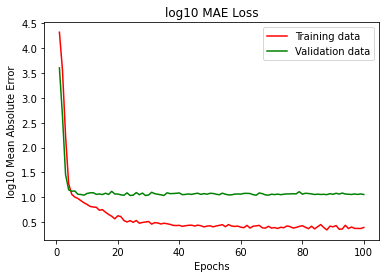

In [27]:
plt.figure()
plt.plot(range(1,101),train_mae_loss_list,'-r',label="Training data")
plt.plot(range(1,101),val_mae_loss_list,'-g',label="Validation data")
plt.gca().set_xlabel("Epochs")
plt.gca().set_ylabel("log10 Mean Absolute Error")
plt.gca().set_title("log10 MAE Loss")
plt.legend()

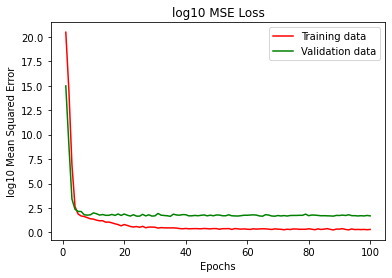

In [28]:
plt.figure()
plt.plot(range(1,101),train_mse_loss_list,'-r',label="Training data")
plt.plot(range(1,101),val_mse_loss_list,'-g',label="Validation data")
plt.gca().set_xlabel("Epochs")
plt.gca().set_ylabel("log10 Mean Squared Error")
plt.gca().set_title("log10 MSE Loss")
plt.legend()

In [29]:
def abs_err(x,y):
    return np.abs(x-y)
def reg_err(x,y):
    return x-y

In [30]:
# Evaluate training distribution
model.eval()
train_mae_loss = []
train_reg_loss = []

for image, label in tqdm(train_loader,desc="Train data: "):
    # Send variables to device
    image = image.to(device)
    label = label.to(device)
    # Run model
    pred = model(image)
    # Move variables to cpu
    pred = pred.cpu().squeeze().detach()
    label = label.cpu().squeeze().detach()
#     print(pred.shape)
#     print(abs_err(pred,label))
    # Compute loss
    train_mae_loss = np.concatenate((train_mae_loss, abs_err(pred,label)))
    train_reg_loss = np.concatenate((train_reg_loss, reg_err(pred,label)))


Train data: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:05<00:00,  8.97it/s]


Text(0.5, 0, 'log10 absolute error')

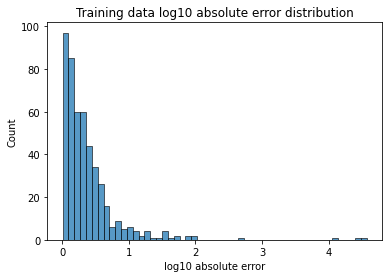

In [31]:
# Plot absolute error (log) distribution for model
sns.histplot(train_mae_loss)#, kde=True)
plt.gca().set_title("Training data log10 absolute error distribution")
plt.gca().set_xlabel("log10 absolute error")

Text(0.5, 0, 'log10 error')

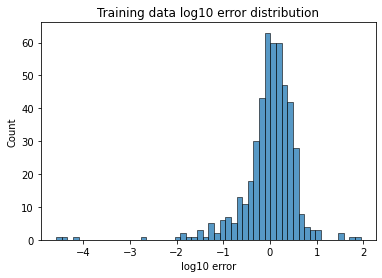

In [32]:
sns.histplot(train_reg_loss)#, kde=True)
plt.gca().set_title("Training data log10 error distribution")
plt.gca().set_xlabel("log10 error")

In [33]:
# Evaluate validation distribution
model.eval()
val_mae_loss = []
val_reg_loss = []

for image, label in tqdm(val_loader,desc="Validation data: "):
    # Send variables to device
    image = image.to(device)
    label = label.to(device)
    # Run model
    pred = model(image)
    # Move variables to cpu
    pred = pred.cpu().squeeze().detach()
    label = label.cpu().squeeze().detach()
#     print(pred.shape)
#     print(abs_err(pred,label))
    # Compute loss
    val_mae_loss = np.concatenate((val_mae_loss, abs_err(pred,label)))
    val_reg_loss = np.concatenate((val_reg_loss, reg_err(pred,label)))


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Text(0.5, 0, 'log10 absolute error')

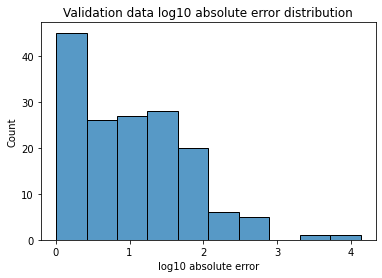

In [34]:
sns.histplot(val_mae_loss)
plt.gca().set_title("Validation data log10 absolute error distribution")
plt.gca().set_xlabel("log10 absolute error")

Text(0.5, 0, 'log10 error')

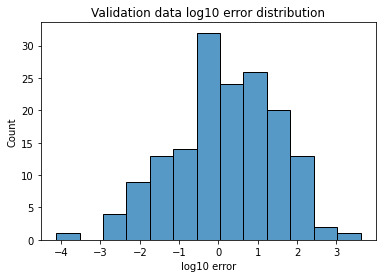

In [35]:
sns.histplot(val_reg_loss)
plt.gca().set_title("Validation data log10 error distribution")
plt.gca().set_xlabel("log10 error")

In [37]:
# Evaluate test distribution
model.eval()
test_mae_loss = []
test_reg_loss = []

for image, label in tqdm(test_loader,desc="Test data: "):
    # Send variables to device
    image = image.to(device)
    label = label.to(device)
    # Run model
    pred = model(image)
    # Move variables to cpu
    pred = pred.cpu().squeeze().detach()
    label = label.cpu().squeeze().detach()
#     print(pred.shape)
#     print(abs_err(pred,label))
    # Compute loss
    test_mae_loss = np.concatenate((test_mae_loss, abs_err(pred,label)))
    test_reg_loss = np.concatenate((test_reg_loss, reg_err(pred,label)))

Test data: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Text(0.5, 0, 'log10 absolute error')

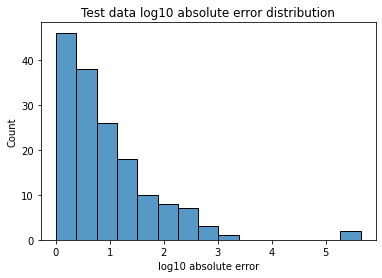

In [38]:
sns.histplot(test_mae_loss)
plt.gca().set_title("Test data log10 absolute error distribution")
plt.gca().set_xlabel("log10 absolute error")

Text(0.5, 0, 'log10 error')

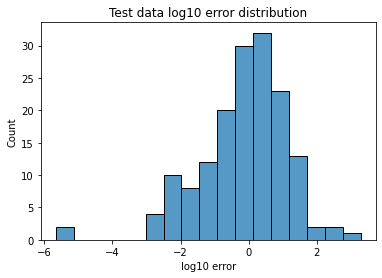

In [39]:
sns.histplot(test_reg_loss)
plt.gca().set_title("Test data log10 error distribution")
plt.gca().set_xlabel("log10 error")